In [1]:
import time
import os 

In [9]:
#from google.colab import drive
#drive.mount('/content/gdrive')
image_dir = os.getcwd() + '/Images/'
model_dir = os.getcwd() + '/Models/'
output_dir = os.getcwd() + '/Output/'

In [2]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
cuda = torch.cuda.is_available()
device = torch.device('cuda' if cuda else 'cpu')
print(device)

import torchvision
from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image
from collections import OrderedDict
import numpy as np

cuda


In [3]:
content_images = ["Content/04.png", "Content/01.png", "Content/05.png", "Content/10.png", "Content/12.png", "Content/19.png"]
style_images = ["Style/01.png", "Style/02.png", "Style/03.png", "Style/10.png", "Style/04.png", "Style/09.png"]
n_iterations = 500

In [5]:
#vgg definition that conveniently let's you grab the outputs from any layer
class VGG(nn.Module):
    def __init__(self, pool='max'):
        super(VGG, self).__init__()
        #vgg modules
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_4 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_4 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        if pool == 'max':
            self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        elif pool == 'avg':
            self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool3 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool4 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool5 = nn.AvgPool2d(kernel_size=2, stride=2)
            
    def forward(self, x, out_keys):
        out = {}
        out['r11'] = F.relu(self.conv1_1(x))
        out['r12'] = F.relu(self.conv1_2(out['r11']))
        out['p1'] = self.pool1(out['r12'])
        out['r21'] = F.relu(self.conv2_1(out['p1']))
        out['r22'] = F.relu(self.conv2_2(out['r21']))
        out['p2'] = self.pool2(out['r22'])
        out['r31'] = F.relu(self.conv3_1(out['p2']))
        out['r32'] = F.relu(self.conv3_2(out['r31']))
        out['r33'] = F.relu(self.conv3_3(out['r32']))
        out['r34'] = F.relu(self.conv3_4(out['r33']))
        out['p3'] = self.pool3(out['r34'])
        out['r41'] = F.relu(self.conv4_1(out['p3']))
        out['r42'] = F.relu(self.conv4_2(out['r41']))
        out['r43'] = F.relu(self.conv4_3(out['r42']))
        out['r44'] = F.relu(self.conv4_4(out['r43']))
        out['p4'] = self.pool4(out['r44'])
        out['r51'] = F.relu(self.conv5_1(out['p4']))
        out['r52'] = F.relu(self.conv5_2(out['r51']))
        out['r53'] = F.relu(self.conv5_3(out['r52']))
        out['r54'] = F.relu(self.conv5_4(out['r53']))
        out['p5'] = self.pool5(out['r54'])
        return [out[key] for key in out_keys]

In [6]:
# gram matrix and loss
class GramMatrix(nn.Module):
    def forward(self, input):
        b,c,h,w = input.size()
        F = input.view(b, c, h*w)
        G = torch.bmm(F, F.transpose(1,2)) 
        G.div_(h*w)
        return G

class GramMSELoss(nn.Module):
    def forward(self, input, target):
        out = nn.MSELoss()(GramMatrix()(input), target)
        return(out)

In [7]:
# pre and post processing for images
img_size = 512 
prep = transforms.Compose([transforms.Resize(img_size),
                           transforms.ToTensor(),
                           transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]), #turn to BGR
                           transforms.Normalize(mean=[0.40760392, 0.45795686, 0.48501961], #subtract imagenet mean
                                                std=[1,1,1]),
                           transforms.Lambda(lambda x: x.mul_(255)),
                          ])
postpa = transforms.Compose([transforms.Lambda(lambda x: x.mul_(1./255)),
                           transforms.Normalize(mean=[-0.40760392, -0.45795686, -0.48501961], #add imagenet mean
                                                std=[1,1,1]),
                           transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]), #turn to RGB
                           ])
postpb = transforms.Compose([transforms.ToPILImage()])
def postp(tensor): # to clip results in the range [0,1]
    t = postpa(tensor)
    t[t>1] = 1    
    t[t<0] = 0
    img = postpb(t)
    return img

In [19]:
#get network
vgg = VGG(pool="max")
vgg.load_state_dict(torch.load(model_dir + 'vgg_conv.pth'))
for param in vgg.parameters():
    param.requires_grad = False
if torch.cuda.is_available():
    vgg.cuda()

In [12]:
def run_transfer(style_name, content_name, init_method="content", max_iter=500, show_iter=50, output_dir=output_dir):
    #load images, ordered as [style_image, content_image]
    img_dirs = [image_dir, image_dir]
    img_names = [style_name, content_name]
    imgs = [Image.open(img_dirs[i] + name) for i,name in enumerate(img_names)]
    imgs_torch = [prep(img) for img in imgs]
    if torch.cuda.is_available():
        imgs_torch = [Variable(img.unsqueeze(0).cuda()) for img in imgs_torch]
    else:
        imgs_torch = [Variable(img.unsqueeze(0)) for img in imgs_torch]
    style_image, content_image = imgs_torch

    if init_method == "random":
        opt_img = Variable(torch.randn(content_image.size()).type_as(content_image.data), requires_grad=True)
    elif init_method == "content":
        opt_img = Variable(content_image.data.clone(), requires_grad=True)
    elif init_method == "style":
        resize_to_content = transforms.Resize((imgs[1].height, imgs[1].width))
        style_image_resized = resize_to_content(imgs[0])
        if torch.cuda.is_available():
            opt_img = Variable(prep(style_image_resized).unsqueeze(0).cuda(), requires_grad=True)
        else:
            opt_img = Variable(prep(style_image_resized).unsqueeze(0), requires_grad=True)

    optimizer = optim.LBFGS([opt_img])
    n_iter=[0]

    #define layers, loss functions, weights and compute optimization targets
    style_layers = ['r11','r21','r31','r41','r51'] 
    content_layers = ['r42']
    loss_layers = style_layers + content_layers
    loss_fns = [GramMSELoss()] * len(style_layers) + [nn.MSELoss()] * len(content_layers)
    if torch.cuda.is_available():
        loss_fns = [loss_fn.cuda() for loss_fn in loss_fns]
        
    #these are good weights settings:
    style_weights = [1e3/n**2 for n in [64,128,256,512,512]]
    content_weights = [1e0]
    weights = style_weights + content_weights

    #compute optimization targets
    style_targets = [GramMatrix()(A).detach() for A in vgg(style_image, style_layers)]
    content_targets = [A.detach() for A in vgg(content_image, content_layers)]
    targets = style_targets + content_targets

    # set up timer
    losses = []

    #run style transfer
    while n_iter[0] <= max_iter:

        def closure():
            optimizer.zero_grad()
            out = vgg(opt_img, loss_layers)
            layer_losses = [weights[a] * loss_fns[a](A, targets[a]) for a,A in enumerate(out)]
            loss = torch.stack(layer_losses, dim=0).sum(dim=0)
            loss.backward()
            n_iter[0]+=1
            if n_iter[0]%show_iter == (show_iter-1):
                print('Iteration: %d, loss: %f'%(n_iter[0]+1, loss.item()))
                losses.append(loss.item())
            return loss
        
        optimizer.step(closure)
        
    #display result
    out_img = postp(opt_img.data[0].cpu().squeeze())
    #plt.imshow(out_img)
    #plt.gcf().set_size_inches(10,10)
    out_img.save(output_dir + "c" + content_name[8:10] + "_s" + style_name[6:8] + ".png")
    return losses

In [81]:
init_content_losses = []
for i in range(len(style_images)):
    init_content_losses.append(run_transfer(style_images[i], content_images[i], "content", 2000, 25, output_dir+'init_content_2000/'))

Iteration: 25, loss: 5074743.000000
Iteration: 50, loss: 2101107.750000
Iteration: 75, loss: 1149279.875000
Iteration: 100, loss: 812278.000000
Iteration: 125, loss: 635183.937500
Iteration: 150, loss: 529838.875000
Iteration: 175, loss: 462025.468750
Iteration: 200, loss: 414782.656250
Iteration: 225, loss: 379207.062500
Iteration: 250, loss: 353861.718750
Iteration: 275, loss: 332772.937500
Iteration: 300, loss: 316382.250000
Iteration: 325, loss: 303352.500000
Iteration: 350, loss: 293136.687500
Iteration: 375, loss: 285062.562500
Iteration: 400, loss: 278599.312500
Iteration: 425, loss: 273355.656250
Iteration: 450, loss: 269022.125000
Iteration: 475, loss: 265090.125000
Iteration: 500, loss: 261600.796875
Iteration: 25, loss: 5071110.000000
Iteration: 50, loss: 2728049.500000
Iteration: 75, loss: 1810823.125000
Iteration: 100, loss: 1220924.625000
Iteration: 125, loss: 870353.812500
Iteration: 150, loss: 639231.500000
Iteration: 175, loss: 491979.718750
Iteration: 200, loss: 39292

In [14]:
init_random_losses = []
for i in range(len(style_images)):
    init_random_losses.append(run_transfer(style_images[i], content_images[i], "random", 2000, 25, output_dir+'init_random_2000/'))

Iteration: 25, loss: 10271922.000000
Iteration: 50, loss: 2859055.000000
Iteration: 75, loss: 1514244.500000
Iteration: 100, loss: 1022002.000000
Iteration: 125, loss: 790584.250000
Iteration: 150, loss: 671896.500000
Iteration: 175, loss: 592274.250000
Iteration: 200, loss: 536550.625000
Iteration: 225, loss: 496510.625000
Iteration: 250, loss: 466436.281250
Iteration: 275, loss: 441505.187500
Iteration: 300, loss: 421095.718750
Iteration: 325, loss: 404098.625000
Iteration: 350, loss: 389424.687500
Iteration: 375, loss: 376812.875000
Iteration: 400, loss: 365153.500000
Iteration: 425, loss: 355927.968750
Iteration: 450, loss: 346901.750000
Iteration: 475, loss: 338883.218750
Iteration: 500, loss: 332071.843750
Iteration: 25, loss: 16787084.000000
Iteration: 50, loss: 2892851.500000
Iteration: 75, loss: 1514590.750000
Iteration: 100, loss: 1045765.937500
Iteration: 125, loss: 801824.625000
Iteration: 150, loss: 646316.750000
Iteration: 175, loss: 541053.500000
Iteration: 200, loss: 46

In [ ]:
init_style_losses = []
for i in range(len(style_images)):
    init_style_losses.append(run_transfer(style_images[i], content_images[i], "style", 2000, 25, output_dir+'init_style_2000/'))

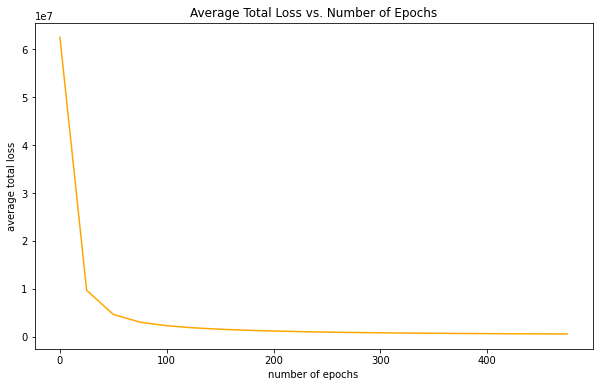

In [17]:
init_content_losses_np = np.array(init_content_losses)
init_random_losses_np = np.array(init_random_losses)
init_style_losses_np = np.array(init_style_losses)
plt.figure(figsize=[10,6])
plt.plot(range(0, 500, 25), init_content_losses_np.mean(axis=0), color = "blue")
plt.plot(range(0, 500, 25), init_random_losses_np.mean(axis=0), color = "orange")
plt.plot(range(0, 500, 25), init_style_losses_np.mean(axis=0), color = "red")
plt.legend(labels = ["Content", "Random", "Style"], loc = "upper right")
plt.xlabel("number of epochs")
plt.ylabel("average total loss")
plt.title("Average Total Loss vs. Number of Epochs")
plt.draw()
plt.ioff()
plt.show()

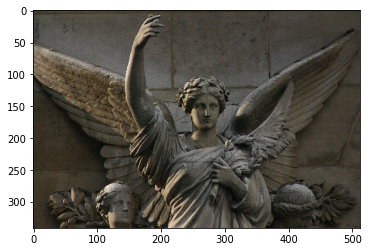

In [48]:
content_name = "Content/01.png"
style_name = "Style/01.png"
temp = Image.open(image_dir+content_name)
plt.imshow(temp)
temp.save(output_dir + "c" + content_name[8:10] + "_s" + style_name[6:8] + ".png")

In [ ]:
for i in range(len(style_images)):
    run_transfer(style_images[i], content_images[i], "content", 1000, 25, output_dir+'init_content_1000/')

In [ ]:
for i in range(len(style_images)):
    run_transfer(style_images[i], content_images[i], "random", 1000, 25, output_dir+'init_random_1000/')

In [ ]:
for i in range(len(style_images)):
    run_transfer(style_images[i], content_images[i], "style", 1000, 25, output_dir+'init_style_1000/')

In [ ]:
for i in range(len(style_images)):
    run_transfer(style_images[i], content_images[i], "content", 500, 25, output_dir+'init_content_500/')

In [ ]:
for i in range(len(style_images)):
    run_transfer(style_images[i], content_images[i], "random", 500, 25, output_dir+'init_random_500/')

In [18]:
for i in range(len(style_images)):
    run_transfer(style_images[i], content_images[i], "style", 500, 25, output_dir+'init_style_500/')

Iteration: 25, loss: 702156.750000
Iteration: 50, loss: 471834.031250
Iteration: 75, loss: 410899.125000
Iteration: 100, loss: 379093.531250
Iteration: 125, loss: 358149.531250
Iteration: 150, loss: 343004.031250
Iteration: 175, loss: 331175.125000
Iteration: 200, loss: 321408.843750
Iteration: 225, loss: 313404.687500
Iteration: 250, loss: 306340.312500
Iteration: 275, loss: 300570.468750
Iteration: 300, loss: 295509.218750
Iteration: 325, loss: 291121.656250
Iteration: 350, loss: 287294.750000
Iteration: 375, loss: 283886.593750
Iteration: 400, loss: 280651.968750
Iteration: 425, loss: 277847.218750
Iteration: 450, loss: 275316.250000
Iteration: 475, loss: 272884.218750
Iteration: 500, loss: 270715.625000
Iteration: 25, loss: 504160.718750
Iteration: 50, loss: 369053.375000
Iteration: 75, loss: 321429.593750
Iteration: 100, loss: 293594.218750
Iteration: 125, loss: 274011.187500
Iteration: 150, loss: 258969.968750
Iteration: 175, loss: 247130.562500
Iteration: 200, loss: 237836.15625

KeyboardInterrupt: 

(512, 341)


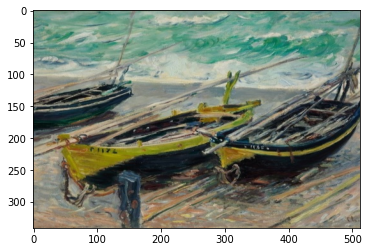

In [51]:
# test block, will eventually remove it
temp1 = Image.open(image_dir+style_name)
img_resize = transforms.Resize((temp.height, temp.width))
temp_resized = img_resize(temp1)
plt.imshow(temp_resized)
temp_resized.save(output_dir + "c" + content_name[8:10] + "_s" + style_name[6:8] + ".png")